# Griffin-Lim algoritam
Griffin-Lim je algoritam za rekonstrukciju signala na osnovu njegovog spektrograma. Algoritam su osnovali Daniel W. Griffin i Jae Lim i kombinacijom njihovih prezimena je dobio ime Griffin-Lim. Iako ovo nije prvi algoritam koji se bavio temom rekonstrukcije signala, ističe se po svojoj jednostavnosti i brzini. Ovaj algoritam se zasniva na Gaborovoj teoriji, kompleksnom matematičkom aparatu koji, zbog svoje složenosti, neće biti detaljno objašnjen u okviru ovog rada.

# Matematika iza Girffin-Lim algoritma
Označimo magnitudni spektrogram od kojeg algoritam polazi sa $s$. Tada postoji signal $x\in\mathbb{R}^L$, gde je $\mathbb{R}^L$ skup svih realnih signala takav da odgovara spektrogramu $s$. Kako bi se od signala $x$ dobio spektrogram $s$ koristi se Kratkoročna Furijeova Transformacija odnosno Short Time Fourier Transform (STFT) i ona predstavlja vrstu Gaborovog preslikavanja ($G$), tako da beležimo $Gx=s$. Uz ovu postavku ako poznajemo samo $s$ i $G$ (što je u našem slučaju STFT) onda tražimo signal $x^*$ takav da se minimizuje greška $||Gx^*-s||_2$ odnosno traži se
$$
\min_{x^*\in\mathbb{R}^L}||Gx^*-s||_2
$$
Na osnovu prethodnog, prirodno se nameće greška
$$
E(x)=\frac{||Gx^*-s||_2}{||s||_2}
$$

Sa matematičke strane, osnovu Griffin-Lim algoritma predstavljaju 2 projekcije spektrograma:
1. $P_{C_1}$: Projekcija spektrograma na set spektrograma $C_1$ za koji važi
$$
C_1 = \{c \mid \exists x \in \mathbb{R} \text{ tkd. } c = Gx\}
$$
Ovo se postiže primenom inverznog Gaborovog preslikavanja preslikavanju $G$ (ISTFT) u oznaci $G^\dagger$ i zatim ponovna primena preslikavanja $G$. Dakle
$$
P_{C_1}(c) = GG^{\dagger}x
$$
Ovime dobijamo spektrogram nekog realnog signala koji je "blizak" našem $s$ ali poseduje i fazu
2. $P_{C_2}$: Projekcija koje našem početnom magnitudnom spektrogramu $s$ dodaje fazu dobijenog spektrogama $c$ pomoću $P_{C_1}$. Set spektrogama $C_2$ je zadat kao
$$
C_2 = \{c \in \mathbb{C}^{MN}\mid |c| = s\}
$$
U ovom slučaju jednakost $|c| = s$ ne mora nužno da bude zadovoljena bitno je da se minimizuje razlika $|||c| - s||_2$. Na ovaj način se spektrogram sa fazom čija je magnituda bliska $s$, tako da ukoliko našem $s$ damo fazu dobijenog $c$ dobijamo novi spektrogram koji ima istu magnitudu, ali sada ima i fazu
$$
P_{C_2}(c) = s*e^{{\cdot}i{\angle}c}
$$

Griffin-Lim se zasniva na uzastopnim primenama $P_{C_1}$ i $P_{C_2}$ preslikavanja i sa velikim brojem iteracija prilazi $s$.
$$
c_n = P_{C_1}(P_{C_2}(c_{n-1})),\ {\angle}c_0\ je\ proizvoljna\ fixna\ vrednost
$$

Na ovaj način uz dovoljan broj iteracija $c_n$ teži $s$, a time i $x^*$ teži $x$

In [1]:
from IPython import display
from scipy.io import wavfile
import numpy as np
from numpy import fft
from matplotlib import pyplot as plt
from scipy import signal

Definišemo STFT funkciju koja predstavlja naše Gaborovo preslikavanje $G$

In [2]:
def stft(data):
#     spectrogram = np.zeros((N-n, n),dtype=np.complex_)
#     for i in range(0, N-n):
#         samples = data[i : i+n ]
#         c = fft.fft(samples*window)
#         spectrogram[i, :] = c
    return signal.stft(data, nperseg = 256, window='nuttall', noverlap=224)[2]

Definišemo ISTFT funkciju koja predstavlja naše Gaborovo preslikavanje $G^{\dagger}$

In [3]:
def istft(spectrogram):
#     x = np.zeros(N)
#     for i in range(0, N-n):
#         x[i : i+n] += window * np.real(fft.ifft(spectrogram[i]))
    return signal.istft(spectrogram, nperseg = 256, window='nuttall', noverlap=224)[1]

Kako je u radu na kom je zasnovan ovaj projekat korišćena spectral signal-to-noise ratio (SSNR) metrika kao merilo greške definisana na sledeći način
$$
SSNR(x)=-\log_{10}(E(x))
$$
tako je i ovde definisana kako bismo na kraju poredili dobijene rezultate sa onima u radu

In [4]:
def SSNR(c, s):
    e = np.sqrt(np.sum((np.abs(c)-s)**2))
    e /= np.sqrt(np.sum(s**2))
    return -10 * np.log10(e)

Ovde su definisane projekcije $P_{C_1}$ i $P_{C_2}$ kao što je objašnjeno iznad
1. $P_{C_1}$: Kako je $G$ u našem slučaku STFT, a $G^\dagger$ ISTFT, onda $GG^{\dagger}x$ definišemo kao $STFT(ISTFT(x))$
2. $P_{C_2}$: Definisana je na identičan način kao i iznad, $s$ predstavlja magnitudni spektrogram od kojeg polacimo, a $c$ spektrogram dobijen iz prethodne iteracije od kojeg uzimamo fazu

In [5]:
def pc1(c):
    return stft(istft(c))

def pc2(c, s):
    return s*np.exp(1.0j*np.angle(c))

Griffin-Lim algoritam (GLA) započinje inicijalizacijom signala, u našem slučaju signal je predstavljen svim nulama, ali mogao je biti i proizvoljni nasumični signal, jedina razlika bi bila brzina konvergencije. Inicijalizuje se i $c_0$ i zatim se naizmeničnim pozivima projekcija $P_{C_1}$ i $P_{C_2}$ spektrogram $c_n$ približava $s$, a $x^*$ se približava $x$

In [6]:
def GLA(s, N, iterations):
    x = np.zeros(N)

    c = s*np.exp(1.0j*np.angle(stft(x)))

    x = istft(c)

    ssnr_history = []

    for i in range(1,iterations+1):
        c = pc1(pc2(c,s))

        ssnr = SSNR(c, s)
        if(i % (iterations/10) == 0):
            print('Reconstruction iteration: {}/{} - SSNR: {}'.format(i, iterations, ssnr))
        ssnr_history.append(ssnr)

    return istft(c), ssnr_history[1:]

#Fast Griffin-Lim algoritam (FGLA)
Fast Griffin-Lim algoritam (FGLA) predstavlja ubraznje po pitanju konvergencije u odnosu na osnovni Griffin-Lim algoritam. Ideja iza ubrzanja je da se koriste veći koraci nego u GLA, a kako bi se povećao korak koristi se informacija o koraku prethodne iteracije. Naime očekuje se da će konvergencija pratiti isti ili slični trend između dva susedna koraka tako da se i može ubrzati uvećavanjem trenutnog koraka za procenat prethodnog. To znači da umesto da radimo
$$
c_n=P_{C_1}(P_{C_2}(c_{n-1}))
$$
možemo da uradimo sledeću izmenu
$$
c_n=P_{C_1}(P_{C_2}(c_{n-1}+\alpha{\Delta}c_{n-1}))
$$
Gde je
$$
{\Delta}c_{n-1}=c_{n-1}-c_{n-2}
$$
U ovom slučaju $\alpha$ predstavlja proizvoljnu konstantu za koju je eksperimentalnom metodom dobijeno da najbolje rezultate daje za vrednosti bliske (ali ne jednake) 1. Konstanta $\alpha$ bi u idealnoj situaciji bila zamenjena nizom $\alpha_n$ tako da se njena vrednost menja kroz iteracije, ali unapred računanje ovog niza nije jednostavna stvar, a dobici na brzini konvergenicije nisu veliki u odnosu na jedinstvenu vrednost $\alpha$, tako da ćemo koristiti fiksnu vrednost


In [7]:
def FGLA(s, N, iterations, alpha = 0.99):
    x = np.zeros(N)

    c_prev = s*np.exp(1.0j*np.angle(stft(x)))
    t_prev = pc2(pc1(c_prev),s)

    # x = istft(c_prev)

    ssnr_history = []

    for i in range(1,iterations+1):
        t = pc1(pc2(c_prev,s))
        c = t + alpha*(t - t_prev)

        t_prev = t
        c_prev = c

        # x = istft(c)

        ssnr = SSNR(c, s)
        if(i % (iterations/10) == 0):
            print('Reconstruction iteration: {}/{} - SSNR: {}'.format(i, iterations, ssnr))
        ssnr_history.append(ssnr)

    return istft(c), ssnr_history[1:]

Pravimo pripreme, određujemo koji će zvukovi biti prerađeni, koje $\alpha$ korišćeno za FGLA i koji je broj iteracija. Zatim za svaki zvuk pojedinačno pravimo spektrogram, otstranjujemo fazu tako da nam ostaje samo spektrogram magnituda $s$ i pokrećemo GLA i FGLA kako bismo mogli da poredimo rezultate. Obe funkcije vraćaju dobijeni signal i istoriju SSNR vrednosti koje ćemo posle ispisati i uporediti sa onima na radu.

In [10]:
sound_names = ["gspi.wav", "cocktailparty.wav", "traindoppler.wav", "greasy.wav", "linus.wav"]
alpha = 0.99
iterations = 100

x_gla_array = []
history_gla_array = []
x_fgla_array = []
history_fgla_array = []
Fs_array = []
for sound_name in sound_names:
  Fs, data = wavfile.read('data/'+sound_name)
  Fs_array.append(Fs)
  N = data.shape[0]
  s = np.abs(stft(data))


  print("======================================================")
  print("Sound name: "+sound_name)
  print("### GLA: ")
  x_gla, history_gla = GLA(s, N, iterations)
  x_gla_array.append(x_gla)
  history_gla_array.append(history_gla)
  print("### FGLA: ")
  x_fgla, history_fgla = FGLA(s, N, iterations, alpha)
  x_fgla_array.append(x_fgla)
  history_fgla_array.append(history_fgla)

Sound name: gspi.wav
### GLA: 
Reconstruction iteration: 10/100 - SSNR: 4.729178731323962
Reconstruction iteration: 20/100 - SSNR: 5.569071182801311
Reconstruction iteration: 30/100 - SSNR: 6.16723853314814
Reconstruction iteration: 40/100 - SSNR: 6.763062752034491
Reconstruction iteration: 50/100 - SSNR: 7.3013609753844975
Reconstruction iteration: 60/100 - SSNR: 7.775638245811375
Reconstruction iteration: 70/100 - SSNR: 8.193932729277895
Reconstruction iteration: 80/100 - SSNR: 8.546171949871512
Reconstruction iteration: 90/100 - SSNR: 8.798196969597985
Reconstruction iteration: 100/100 - SSNR: 8.994647017530422
### FGLA: 
Reconstruction iteration: 10/100 - SSNR: 5.478148256594678
Reconstruction iteration: 20/100 - SSNR: 7.785510871410322
Reconstruction iteration: 30/100 - SSNR: 9.236801551158074
Reconstruction iteration: 40/100 - SSNR: 10.155614232485263
Reconstruction iteration: 50/100 - SSNR: 10.76039027342431
Reconstruction iteration: 60/100 - SSNR: 11.214965627995895
Reconstruct

Ovde jednostavno prikazujemo dobijene vrednosti za svaki obrađeni zvuk. Pravi se grafik SSNR istorija za GLA i FGLA za svaki zvuk i na kraju može da se odsluša dobijeni rekonstruisani zvučni signal

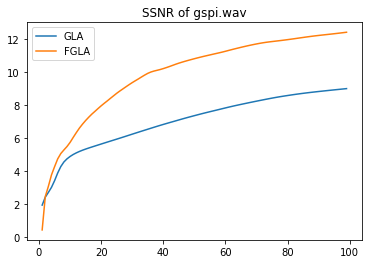

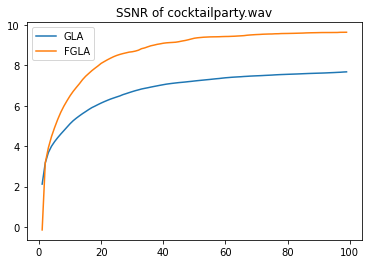

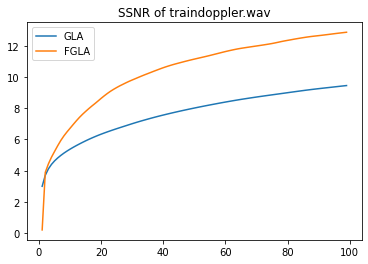

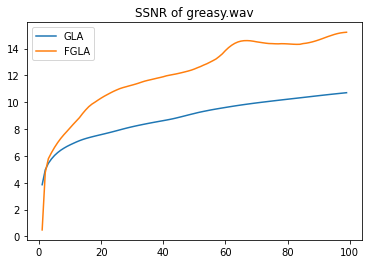

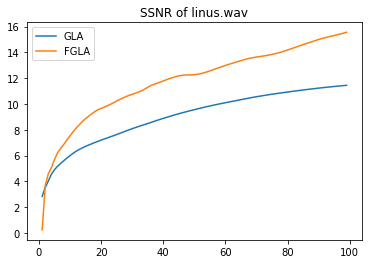

In [11]:
for i in range(len(sound_names)):
  it_vals = range(1, iterations)
  plt.title('SSNR of '+sound_names[i])
  plt.plot(it_vals, history_gla_array[i], label='GLA')
  plt.plot(it_vals, history_fgla_array[i], label='FGLA')
  plt.legend(loc='best')
  plt.show()
  display.display(display.Audio(data=x_fgla_array[i], rate=Fs_array[i]))